In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

In [2]:
df = pd.read_csv("city_data.csv")

In [3]:
geometry = [Point(xy) for xy in zip(df['Boylam'], df['Enlem'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [4]:
turkey_map = gpd.read_file("/home/emirslh0/Masaüstü/Turkey-Map/ne_10m_admin_0_countries.")
ill_map = gpd.read_file("/home/emirslh0/Masaüstü/Turkey-Map/gadm41_TUR_shp/gadm41_TUR_1.shp")
turkey_map = turkey_map[turkey_map['ADMIN'] == "Turkey"]

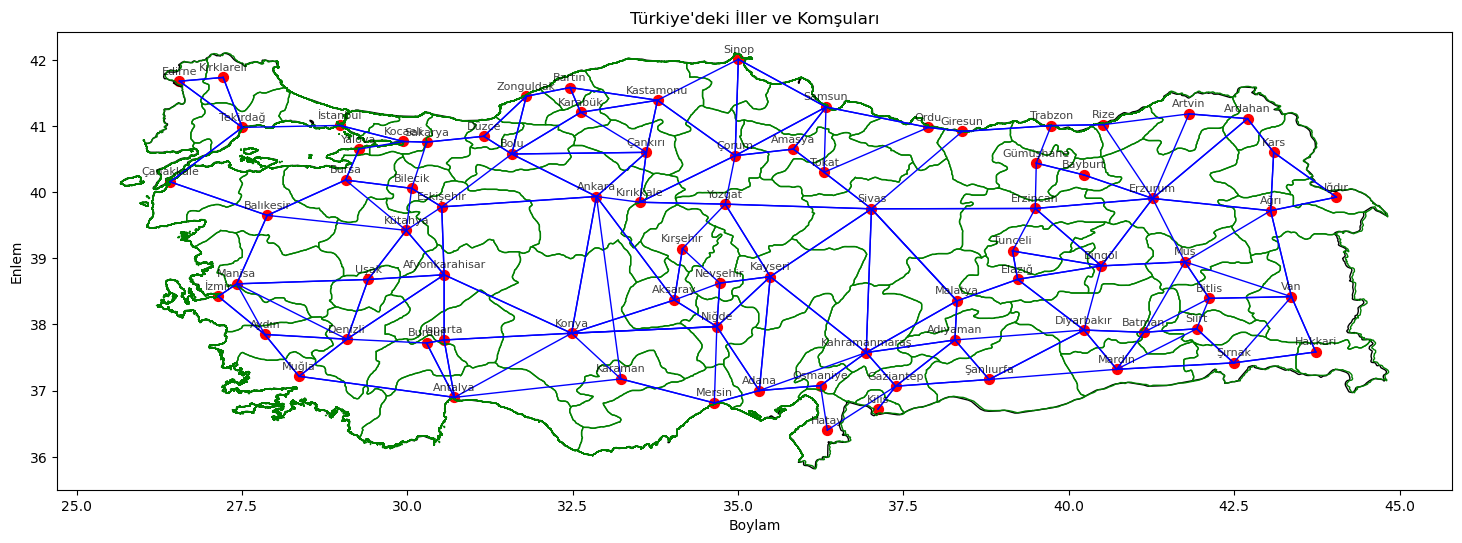

In [5]:
fig, ax = plt.subplots(figsize=(18, 18))
turkey_map.boundary.plot(ax=ax, linewidth=1, color='black')  # Türkiye sınırlarını çiz
ill_map.boundary.plot(ax=ax, linewidth=1, color='green')  # İllerin sınırlarını çiz
gdf.plot(ax=ax, color='red', markersize=50)  # Şehirlerin merkezleri


for index, row in gdf.iterrows():
    komsular = row['Komsular'].split(", ")
    for komsu in komsular:
        if komsu in df['il'].values:
            komsu_row = df[df['il'] == komsu].iloc[0]
            komsu_geometry = gdf[gdf['il'] == komsu].geometry.values[0]
            line = LineString([row['geometry'], komsu_geometry])
            ax.plot(*line.xy, color='blue', linewidth=1)

            

for x, y, label in zip(gdf['Boylam'], gdf['Enlem'], gdf['il']):
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black', alpha=0.75)


plt.title("Türkiye'deki İller ve Komşuları")
plt.xlabel("Boylam")
plt.ylabel("Enlem")
plt.show()

In [6]:
import networkx as nx
from math import radians, sin, cos, sqrt, atan2

In [7]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Dünya yarıçapı (km)
    d_lat = radians(lat2 - lat1)
    d_lon = radians(lon2 - lon1)
    a = sin(d_lat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(d_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [8]:
G = nx.Graph()
city_data = pd.read_csv("city_data.csv")

In [9]:
for _, row in city_data.iterrows():
    city = row['il']
    lat1, lon1 = row['Enlem'], row['Boylam']
    neighbors = row['Komsular'].split(", ")
    
    for neighbor in neighbors:
        neighbor_row = city_data[city_data['il'] == neighbor]
        
        if not neighbor_row.empty:
            lat2, lon2 = neighbor_row.iloc[0]['Enlem'], neighbor_row.iloc[0]['Boylam']
            distance = haversine(lat1, lon1, lat2, lon2)
            G.add_edge(city, neighbor, weight=distance)

Ziyaret edilen şehirler: {'Bursa'}
Bursa -> Bilecik (86.2 km) seçildi.
Ziyaret edilen şehirler: {'Bursa', 'Bilecik'}
Bilecik -> Eskişehir (49.7 km) seçildi.
Ziyaret edilen şehirler: {'Bursa', 'Bilecik', 'Eskişehir'}
Eskişehir -> Ankara (200.4 km) seçildi.
Ziyaret edilen şehirler: {'Bursa', 'Bilecik', 'Eskişehir', 'Ankara'}
Ankara -> Kırıkkale (56.8 km) seçildi.
Ziyaret edilen şehirler: {'Ankara', 'Bursa', 'Eskişehir', 'Bilecik', 'Kırıkkale'}
Kırıkkale -> Yozgat (110.3 km) seçildi.
Ziyaret edilen şehirler: {'Ankara', 'Bursa', 'Eskişehir', 'Yozgat', 'Bilecik', 'Kırıkkale'}
Yozgat -> Sivas (189.0 km) seçildi.
Ziyaret edilen şehirler: {'Sivas', 'Ankara', 'Bursa', 'Eskişehir', 'Yozgat', 'Bilecik', 'Kırıkkale'}
Sivas -> Malatya (190.9 km) seçildi.
Ziyaret edilen şehirler: {'Sivas', 'Ankara', 'Bursa', 'Eskişehir', 'Yozgat', 'Malatya', 'Bilecik', 'Kırıkkale'}
Malatya -> Elazığ (87.6 km) seçildi.
Ziyaret edilen şehirler: {'Elazığ', 'Sivas', 'Ankara', 'Bursa', 'Eskişehir', 'Yozgat', 'Malatya', '

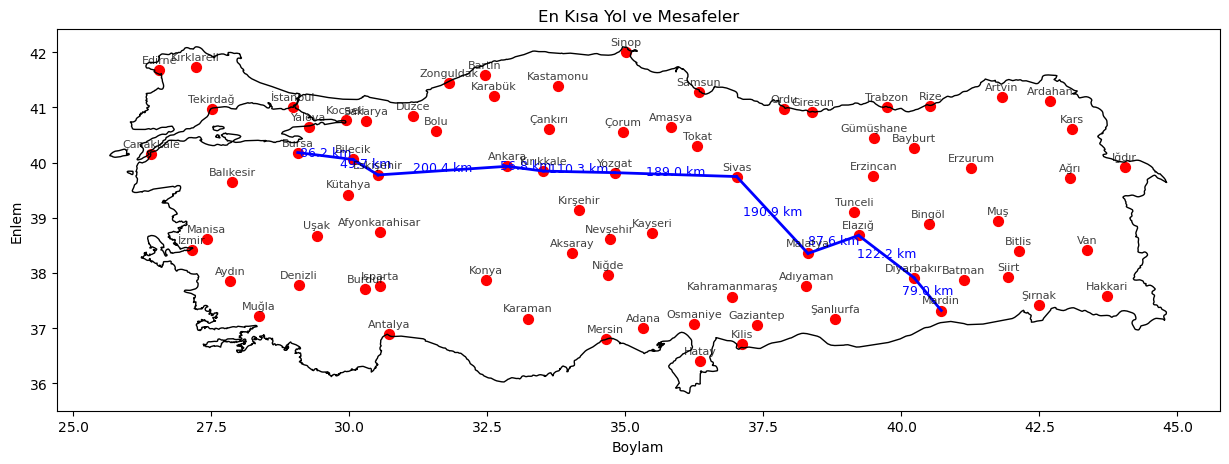

En kısa rota: Bursa (86.2 km) -> Bilecik (49.7 km) -> Eskişehir (200.4 km) -> Ankara (56.8 km) -> Kırıkkale (110.3 km) -> Yozgat (189.0 km) -> Sivas (190.9 km) -> Malatya (87.6 km) -> Elazığ (122.2 km) -> Diyarbakır (79.0 km) -> Mardin
Toplam mesafe: 1172.103012472326 km


In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
turkey_map.boundary.plot(ax=ax, linewidth=1, color='black')
gdf.plot(ax=ax, color='red', markersize=50)

source = "Bursa"
target = "Mardin"

shortest_path = nx.dijkstra_path(G, source=source, target=target, weight='weight')

total_distance = 0

# Dijkstra algoritmasının adım adım simülasyonu
visited = set()  
for i in range(len(shortest_path) - 1):
    start_city = shortest_path[i]
    end_city = shortest_path[i + 1]
    
    start_coord = gdf[gdf['il'] == start_city].geometry.values[0]
    end_coord = gdf[gdf['il'] == end_city].geometry.values[0]
    

    line = LineString([start_coord, end_coord])
    ax.plot(*line.xy, color='blue', linewidth=2)
    

    distance = G[start_city][end_city]['weight']
    total_distance += distance  
    mid_x = (start_coord.x + end_coord.x) / 2
    mid_y = (start_coord.y + end_coord.y) / 2
    ax.text(mid_x, mid_y, f"{distance:.1f} km", color="blue", fontsize=9, ha='center')
    
    visited.add(start_city)
    print(f"Ziyaret edilen şehirler: {visited}")
    print(f"{start_city} -> {end_city} ({distance:.1f} km) seçildi.")
    
    if end_city in visited:
        print(f"{end_city} daha önce ziyaret edildi, bu yol iptal edildi.")
        break


for x, y, label in zip(gdf['Boylam'], gdf['Enlem'], gdf['il']):
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black', alpha=0.75)

plt.title("En Kısa Yol ve Mesafeler")
plt.xlabel("Boylam")
plt.ylabel("Enlem")
plt.show()


shortest_distances = [G[shortest_path[i]][shortest_path[i + 1]]['weight'] for i in range(len(shortest_path) - 1)]
distance_info = " -> ".join([f"{shortest_path[i]} ({shortest_distances[i]:.1f} km)" for i in range(len(shortest_path) - 1)]) + f" -> {shortest_path[-1]}"
print("En kısa rota:", distance_info)
print("Toplam mesafe:", total_distance, "km")

In [13]:
import numpy as np



def dijkstra_step_by_step(G, source, target):
    visited = set()  
    distances = {node: np.inf for node in G.nodes}  
    distances[source] = 0  
    previous_nodes = {node: None for node in G.nodes}  

    while visited != set(G.nodes):  
        
        unvisited_nodes = {node: distances[node] for node in G.nodes if node not in visited}
        current_node = min(unvisited_nodes, key=unvisited_nodes.get) 

        if current_node == target: 
            break

        visited.add(current_node) 

        for neighbor, attrs in G[current_node].items():
            if neighbor not in visited:
                new_distance = distances[current_node] + attrs['weight']
                if new_distance < distances[neighbor]:  
                    distances[neighbor] = new_distance
                    previous_nodes[neighbor] = current_node
        
        print(f"Ziyaret edilen: {current_node}, Mesafeler: {distances}")
    
    path = []
    while target is not None:
        path.append(target)
        target = previous_nodes[target]
    path.reverse()  

    return path, distances[path[-1]]


shortest_path, total_distance = dijkstra_step_by_step(G, source, target)

print("En kısa rota:", " -> ".join(shortest_path))
print("Toplam mesafe:", total_distance, "km")


Ziyaret edilen: Bursa, Mesafeler: {'Adana': inf, 'Mersin': inf, 'Osmaniye': inf, 'Kahramanmaraş': inf, 'Niğde': inf, 'Kayseri': inf, 'Adıyaman': inf, 'Malatya': inf, 'Şanlıurfa': inf, 'Gaziantep': inf, 'Afyonkarahisar': inf, 'Kütahya': 115.26675880599274, 'Eskişehir': inf, 'Konya': inf, 'Isparta': inf, 'Denizli': inf, 'Uşak': inf, 'Ağrı': inf, 'Kars': inf, 'Iğdır': inf, 'Van': inf, 'Muş': inf, 'Erzurum': inf, 'Aksaray': inf, 'Ankara': inf, 'Kırşehir': inf, 'Nevşehir': inf, 'Amasya': inf, 'Samsun': inf, 'Tokat': inf, 'Çorum': inf, 'Çankırı': inf, 'Kırıkkale': inf, 'Bolu': inf, 'Karaman': inf, 'Antalya': inf, 'Muğla': inf, 'Burdur': inf, 'Ardahan': inf, 'Artvin': inf, 'Rize': inf, 'Aydın': inf, 'İzmir': inf, 'Manisa': inf, 'Balıkesir': 117.14469372555415, 'Bursa': 0, 'Çanakkale': inf, 'Bartın': inf, 'Zonguldak': inf, 'Karabük': inf, 'Kastamonu': inf, 'Batman': inf, 'Siirt': inf, 'Mardin': inf, 'Diyarbakır': inf, 'Bayburt': inf, 'Gümüşhane': inf, 'Bilecik': 86.17504130873056, 'Sakarya': i